In [1]:
from track_utils_4_0_0 import*
from track_live_utils import*

In [2]:
#Connect to the the scope and stage and camera
core = Core()
print(core)
stage_device_label = core.get_xy_stage_device()

In [70]:
x_init, y_init, z_init = init(core)

In [68]:
z_mid = mid(core)

In [67]:
x_fin, y_fin, z_fin = fin(core)

In [66]:
core.set_xy_position(x_fin,y_fin)
core.wait_for_device(core.get_xy_stage_device())
core.set_position(z_fin)

In [69]:
core.set_xy_position(x_init,y_init)
core.wait_for_device(core.get_xy_stage_device())
core.set_position(z_init)


In [38]:
def initial(img, thresh, ecc):
    # frame=img
    signal=0
    
    cell=False
    L1=img[0][1::2, 1::2]
    L2=img[1][1::2, 1::2]
    if np.mean(L1)>np.mean(L2):
        b=[L1,L2]
        # frame=[img[0],img[1]]
    else:
        b=[L2,L1]
        # frame=[img[1],img[0]]
    L2=img[1][1::2, 1::2]
    if np.mean(L1)>np.mean(L2):
        b=[L1,L2]
    else:
        b=[L2,L1]
    f = tp.locate(b[0], 41, preprocess=True, percentile=99,  invert=True, max_iterations=1, characterize =True, topn=1)
    if len(f)<1:
        signal=0
    elif len(f)>0:
        f=f.max()
        signal=f.signal
        ecen=f.ecc
        x=f.x
        y=f.y
    if signal>thresh  and x<200 and ecen<ecc and y>50 and y<270:
        cell=True
    return cell

In [8]:
zi=np.linspace(z_init,z_mid,150)
zf=np.linspace(z_mid,z_fin,150)
zs=np.hstack([zi,zf])
xs=np.linspace(x_init,x_fin,300)
core.set_xy_position(x_init,y_init)
core.wait_for_device(core.get_xy_stage_device())
core.set_position(z_init)
core.wait_for_device(core.get_xy_stage_device())
core.set_xy_position(x_fin,y_fin) 
# time.sleep(0.01)
j=0

while core.get_x_position()<x_fin-1:
    x_pos=core.get_x_position()
    if x_pos>xs[j+1]:
            passed=True
    else:
            passed=False
    if passed==True:
            core.set_position(zs[j])
            j=j+1
            passed=False

In [54]:
def run(core,press, x_init,y_init, z_init, x_fin,y_fin, z_fin, z_mid, thresh, ecc):
    fgt_init()   
    fgt_set_pressure(0, press)
    core.set_xy_position(x_init,y_init)
    core.wait_for_device(core.get_xy_stage_device())
    core.set_position(z_init)
    core.wait_for_device(core.get_xy_stage_device())
    i=0
    j=0
    p=press
    imgs=[]
    locx=[]
    pressures=[]
    run=False
    cell=False
    passed=False
    x_old=0
    y_old=0
    x=[180,180,180]
    y=[145,145,145] 
    t=[]
    pid = PID(0.3, 0.05, 1, setpoint=180)
    pid.output_limits = (-1, 1)
    zi=np.linspace(z_init,z_mid,150)
    zf=np.linspace(z_mid,z_fin,150)
    zs=np.hstack([zi,zf])
    xs=np.linspace(x_init,x_fin,300)
    with Camera() as cam: # Acquire and initialize Camera
        # Start recording
        fgt_init()
        fgt_set_pressure(0, p)
        # core.wait_for_device(core.get_xy_stage_device())
        # while cell==False:
            # print(time.time())
        while run==False:
            cam.start()
            frame = [cam.get_array() for n in range(2)]
            cell=initial(frame, thresh, ecc)
            # print(cell)
            # print(time.time())
            if cell ==True:
                # cam.stop()
                core.set_xy_position(x_fin,y_fin) 
                # time.sleep(0.01)
                cam.start()  
                
                while  cell==True and core.get_x_position()<x_fin-5:
                    x_pos=core.get_x_position()
                    if x_pos>xs[j+1]:
                            passed=True
                    else:
                            passed=False
                    if passed==True:
                            core.set_position(zs[j])
                            j=j+1
                            passed=False
                    x_old=np.mean(x[-3:])
                    # print(x_old)
                    y_old=np.mean(y[-3:])
                    img = [cam.get_array() for n in range(8)] # Get 10 frames
                    # frame = img#np.maximum(data2[i][0],data2[i][1])
                    pt, ts = feedback(img,x_old, y_old, thresh, ecc)
                    x_pt=pt[0]; y_pt=pt[1]
                    # if x_pt==0:
                    #     x_pt=x_old
                    imgs.append(img)
                    drift=2*0.1725*(x-x_old)
                    x_pid=np.mean(x[-3:])
                    pressure=pid(x_pid)
                    locx.append(x_pt)
                    x.append(x_pt)
                    y.append(y_pt)
                    print(x_pt)
                    t.append(i)
            # print(drift)
                    if  ts > 0 and p>10 and  p<1499:
                        if p<press-150:
                            p=press-150
                    #     fgt_set_pressure(0, p)
                        elif p>press+150:
                            p=press+150
                        else:
                            p+=pressure
                    
                    else:
                        p=p

                # print(time.time())
                    pressures.append(p)
                    fgt_set_pressure(0, p)
                    # x_old=x
                    # y_old=y
                    i=i+1
                run=True
            else:
                run==False
            cam.stop()
    cv.destroyAllWindows()
    plt.plot(locx)   
    return imgs, pressures    


In [ ]:
with Camera() as cam: 
    
    i=0
    imgs = []
    while i <10:
        cam.start()
        print(i)
        img = [cam.get_array() for n in range(8)]
        # print(img)
        i = i+1
        # imgs.append(img)
        cam.stop()


In [ ]:
i=0
j=0
run=True
passed=False
zs=np.linspace(z_init,z_fin,100)
xs=np.linspace(x_init,x_fin,100)
imgs=[]
# x=np.linspace(z_init,z_fin,300)
# with Camera() as cam:
#     cam.start()
core.set_xy_position(x_fin,y_fin)
while run==True:
            x_pos=core.get_x_position()
            if x_pos>xs[j+1]:
                    passed=True
            else:
                    passed=False
            if passed==True:
                    core.set_position(zs[j])
                    j=j+1
                    passed=False
            #     j=j+i
            # core.set_position(x[i])
            # img = [cam.get_array() for n in range(8)]
            # time.sleep(0.01)
            # imgs.append(img)
            print(x_pos)
            i=i+1
            if core.get_x_position()>x_fin-1:
                   run=False


In [ ]:
i=0
x=np.linspace(z_init,z_fin,100)
while i<100:
    print(x)
    i=i+1

In [14]:
set_to_start(core,200,x_init,y_init)

47.273620879586474
96.08087386644682
140.65944897794296
157.17788343306827
135.5141261498029
97.84405715701661
48.91126223254271
17.868514982983314
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
339.23009958451496
285.99830486373713
242.97354964964333
183.70039029149896
116.55679287305122
68.25863611956328
18.99554619319892
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
323.08728516868234
261.8970812897001
216.15076598848992
154.36677724735011
87.49226305609284
47.7302299936988
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
285.3078042772366
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
153.71111703545722
103.25037465210876
41.944626986264474
0
0
0
0
0
284.2055621228147
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
122.79076558080116
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

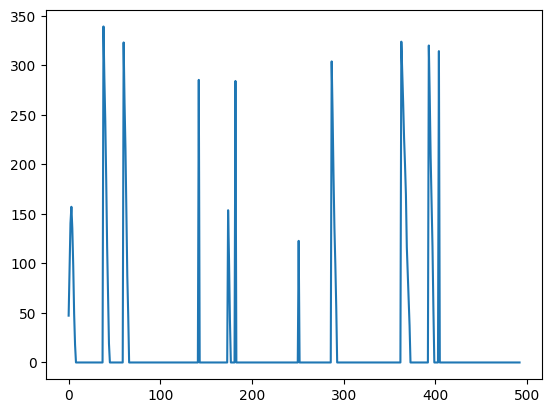

In [84]:
imgs, pressures= run(core,440, x_init,y_init,z_init, x_fin,y_fin,z_fin, z_mid, 25,0.6)

In [ ]:
name='track_vids/20250924_MGH2207/3/vids/20250924_MGH2207_3_'
collect(core,name,420,23,41, x_init,y_init,z_init, x_fin,y_fin,z_fin, z_mid, 25,0.6)

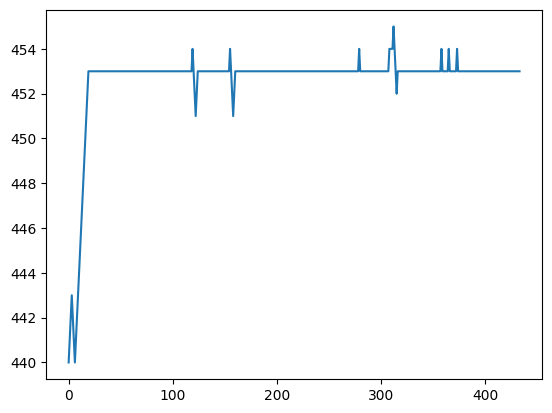

In [106]:
plt.plot(pressures)

In [77]:
save('track_vids/20250924_MGH2207/3/vids/20250924_MGH2207_3_41.h5', imgs)

In [78]:
save('track_vids/20250924_MGH2207/3/pressure/20250924_MGH2207_3_41_press.h5', pressures)

In [2]:
vid=load('track_vids/20250910_MGH2194/21/20250910_MGH2194_21_4.h5')

In [16]:
len(vid)

97

In [17]:
def view_50(imgs):
    x=[0,0,0]
    y=[0,0,0] 
    i=0
    j=0         
    while j<len(imgs):
        img=imgs[j]
        for img in img:
            # cell=initial(img)
            # print(cell)
            # gray = cv.cvtColor(frame, cv.COLOR_BayerBG2GRAY)
            b=img[1::2, 1::2]
            # L2=img[1][1::2, 1::2]
            # print(np.mean(L1))
            # b1=np.max([L1, L2],axis=0)
            # b2=np.min([L1, L2],axis=0)
            # if np.mean(L1)>np.mean(L2):
            #     b=[L1,L2]
            # else:
            #     b=[L2,L1]
            
            # f = tp.locate(b, 31, preprocess=True, percentile=99,  invert=True, max_iterations=1, characterize =True, topn=1)
            # t=f[f['signal']==f['signal'].max()]
            
            frame = cv.cvtColor(b, cv.COLOR_BayerBG2GRAY)
            # # # print(signal)
            # signal=f.signal.values[0]
            # # ecc=f.ecc.values[0]
            # xf=f.x.values[0]
            # yf=f.y.values[0]
            # # # signal=int(pt[2])
            # x_pt=int(xf)
            # y_pt=int(yf)
            # # gray=cv.resize(frame, dsize=(720, 540), interpolation=cv.INTER_CUBIC).astype("uint8")
            # # # if signal>14:
            # # cv.rectangle(frame, (x_pt-20, y_pt-20), (x_pt+20, y_pt+20), (255,100,200),2)
            # # cv.putText(frame, str('%f' %ecc), (x_pt, y_pt), cv.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 2)
            # cv.putText(frame, str('%f' %signal), (x_pt, y_pt - 30), cv.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 2)
            #     # drift=0.1725*(x-x_old)
            cv.imshow('Single Track', frame)
            # # press 'q' to bre
            cv.waitKey(1)
            i=i+1
        j=j+1
    cv.destroyAllWindows()

In [81]:
view_50(imgs)

KeyboardInterrupt: 

In [ ]:
plt.imshow(imgs[0][2])

In [24]:
def pad_wall(grad):
    W = 2 # window length of neighbors
    thresh = 0.1
    mask = grad < thresh
    kernel = np.ones(2*W+1)
    mask_extended = binary_dilation(mask, kernel)
    grad[mask_extended] = 0
    return grad
def find_wall(img):
    img=img.astype('uint8')
    Gy = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=3)
    aGy=abs(Gy)
    grad=np.median(aGy,axis=1)
    # plt.plot(grad)
    grad=np.where(grad > 40, 0, 1)
    grad=pad_wall(grad)
    return grad
def mass(Hb):
    parea=(6.9/20)**2; 
    Hb=Hb.astype('uint8')
    Gy = cv.Sobel(Hb, cv.CV_64F, 0, 1, ksize=3)
    aGy=abs(Gy)
    means=(np.mean(aGy, axis=0))
    fwhm=(np.max(means))/2
    x=np.delete(Hb,np.where(means>fwhm), axis=1)
    means=(np.mean(x, axis=1))
    Hbnorm=Hb/means[:,None]
    Hbnorm[Hbnorm <= 0] = 1
    Hbnorm[Hbnorm >= 1] = 1
    hbmass=((parea*(10**-8)*64500*np.sum(np.sum((-np.log10(Hbnorm))))))
    return hbmass

def saturation(frames): #Calcuate cell saturation
     #camera pixel area
    b=[frames[0],frames[1]]
    #Molecular absorbtion coefficints of something like that ~chemistry~
    w430_o = 2.1486*(10**8)
    w430_d = 5.2448*(10**8)
    w410_o = 4.6723*(10**8)
    w410_d = 3.1558*(10**8)

    mass410=mass(b[1])
    mass430=mass(b[0])

    e=mass410 #410
    f=mass430 #430
    #Set absorbtion values to equation constants
    a=w410_d
    b=w410_o
    c=w430_d
    d=w430_o
                
    #Calcuate mass of oxygenated and deoxygenated hemoglobin
    Mo=(e*c-a*f)/(b*c-a*d)
    Md=(b*f-e*d)/(b*c-a*d)

    saturation = Mo/(Mo+Md)
    hbmass=Mo+Md
    # print(Mo)
    # print('$')
    # print(Md)
    return saturation, hbmass
def segment(frames,x_old, y_old,BL):
    img=frames
    if x_old<1 or y_old<1:   
        x_old=180; y_old=135
    L1=img[0][1::2, 1::2]
    L2=img[1][1::2, 1::2]
    R1=img[0][::2, ::2]
    R2=img[1][::2, ::2]
    if np.mean(L1)>np.mean(L2):
        b=[L1,L2]
        frame=[L1,L2,R1,R2]
    else:
        b=[L2,L1]
        frame=[L2,L1,R2,R1]
    frame=bleed(frame,BL)
    top=[np.mean(frame[2][int(0):int(10), int(0):int(40)]),np.mean(frame[3][int(0):int(10), int(0):int(40)])]
    grad430=find_wall(frame[2])
    grad410=find_wall(frame[3])
    b430=np.delete(frame[0], np.where(grad430 < 1), axis=0)
    r430=np.delete(frame[2], np.where(grad430 < 1), axis=0)
    pt430=[(np.argwhere(b430 == b430.min()))][0][0]
    y430=pt430[0]; x430=pt430[1]
    b410=np.delete(frame[1], np.where(grad410 < 1), axis=0)
    r410=np.delete(frame[3], np.where(grad410 < 1), axis=0)
    pt410=[(np.argwhere(b410 == b410.min()))][0][0]
    y410=pt410[0]; x410=pt410[1]
    frames=[b430[int(y430)-10:int(y430)+10, int(x410-20):int(x410+20)],b410[int(y410)-10:int(y410)+10, int(x410-20):int(x410+20)],r430[int(y430)-10:int(y430)+10, int(x430-20):int(x430+20)],r410[int(y410)-10:int(y410)+10, int(x410-20):int(x410+20)]]

    return frames, top, pt430, pt410
def main_run(video): #Run the anaylsis in the video
    BL=getBL()
    i=0
    x_old=0
    y_old=0
    saturations=[]
    imgs=[]
    volumes=[]
    hgb=[]
    x=[0,0,0]
    y=[0,0,0]
    I430=[]
    I410=[]
    while i<len(video):
        frame1=video[i][0:2]
        frame2=video[i][2:4]
        frame3=video[i][2:6]
        frame4=video[i][6:8]
        frames=[frame1,frame2, frame3, frame4]
        for frame in frames:
            x_old=np.mean(x[-3:])
            y_old=np.mean(y[-3:])
            frame, top, pt430, pt410 = segment(frame,x_old, y_old,BL)
            # print(pt430)
            # print(pt410)
            if pt430[1]>=21 and pt410[1]>21 and pt430[1]<339 and pt410[1]<339 and pt430[0]>11 and pt410[0]>11 and pt430[0]<239 and pt410[0]<239:
                sats, hbmass=saturation(frame)
                saturations.append(sats)
                hgb.append(hbmass)
                img, vol=net(frames, top)
                imgs.append(img)
                # volumes.append(vol)
                x.append(pt430[1])
                # y.append(pt410[1])
                # I430.append(blue_top[0])
                # I410.append(blue_top[1])
            else:
                saturations.append(np.nan)
                # volumes.append(np.nan)
                hgb.append(np.nan)
                # imgs.append(np.zeros([81,81,3]))
                x.append(300)
                # I430.append(np.nan)
                # I410.append(np.nan)
        i=i+1
    return imgs, saturations, volumes, x, hgb


In [60]:
img, saturations, volumes, x, hbmass= main_run(imgs)

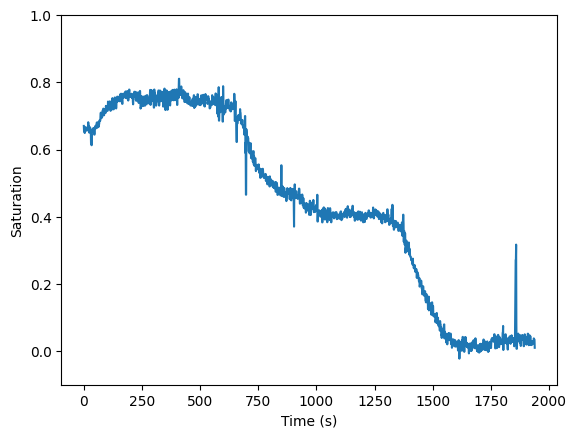

In [61]:
fig, ax = plt.subplots()
plt.plot(saturations)
ax.set_ylim(-0.1, 1)
ax.set_ylabel('Saturation')
ax.set_xlabel('Time (s)')
plt.show()

In [64]:
def collect(core, name, press, start, end, x_init,y_init, z_init, x_fin,y_fin, z_fin, z_mid, thresh, ecc):
    n=start
    
    while n<end:
        fgt_init()
        fgt_set_pressure(0, press)
        core.set_xy_position(x_init,y_init)
        core.wait_for_device(core.get_xy_stage_device())
        core.set_position(z_init)
        core.wait_for_device(core.get_xy_stage_device())
        i=0
        j=0
        p=press
        imgs=[]
        locx=[]
        pressures=[]
        run=False
        cell=False
        passed=False
        x_old=0
        y_old=0
        x=[180,180,180]
        y=[145,145,145] 
        t=[]
        pid = PID(0.3, 0.05, 1, setpoint=180)
        pid.output_limits = (-1, 1)
        zi=np.linspace(z_init,z_mid,150)
        zf=np.linspace(z_mid,z_fin,150)
        zs=np.hstack([zi,zf])
        xs=np.linspace(x_init,x_fin,300)
        with Camera() as cam: # Acquire and initialize Camera
            # Start recording
            fgt_init()
            fgt_set_pressure(0, p)
            # core.wait_for_device(core.get_xy_stage_device())
            # while cell==False:
                # print(time.time())
            while run==False:
                cam.start()
                frame = [cam.get_array() for n in range(2)]
                cell=initial(frame, thresh, ecc)
                # print(cell)
                # print(time.time())
                if cell ==True:
                    # cam.stop()
                    core.set_xy_position(x_fin,y_fin) 
                    # time.sleep(0.01)
                    cam.start()  
                    
                    while  cell==True and core.get_x_position()<x_fin-1:
                        x_pos=core.get_x_position()
                        if x_pos>xs[j+1]:
                                passed=True
                        else:
                                passed=False
                        if passed==True:
                                core.set_position(zs[j])
                                j=j+1
                                passed=False
                        x_old=np.mean(x[-3:])
                        # print(x_old)
                        y_old=np.mean(y[-3:])
                        img = [cam.get_array() for n in range(8)] # Get 10 frames
                        # frame = img#np.maximum(data2[i][0],data2[i][1])
                        pt, ts = feedback(img,x_old, y_old, thresh, ecc)
                        x_pt=pt[0]; y_pt=pt[1]
                        imgs.append(img)
                        drift=2*0.1725*(x-x_old)
                        x_pid=np.mean(x[-3:])
                        pressure=pid(x_pid)
                        locx.append(x_pt)
                        x.append(x_pt)
                        y.append(y_pt)
                        print(x_pt)
                        t.append(i)
                # print(drift)
                        if  ts > 0 and p>100 and  p<1499:
                            if p<press-150:
                                p=press-150
                        #     fgt_set_pressure(0, p)
                            elif p>press+150:
                                p=press+150
                            else:
                                p+=pressure
                        
                        else:
                            p=p

                        # print(p)
                        pressures.append(p)
                        fgt_set_pressure(0, p)
                        # x_old=x
                        # y_old=y
                        i=i+1
                    run=True
                else:
                    run==False
                cam.stop()
        print(n)
        if locx.count(0)<80:

            path=name+str(n)+'.h5'
            path2=name +str(n)+'_press'+'.h5'#'track_vids/20250313_MGH2118/0/press/20250313_MGH2118_21_press_'+str(n)+'.h5'
            with h5py.File(path,'w') as h5f:
                h5f.create_dataset("data", data=imgs)
            with h5py.File(path2,'w') as h5f:
                h5f.create_dataset("data", data=pressures)
            n=n+1
        else:
            n=n


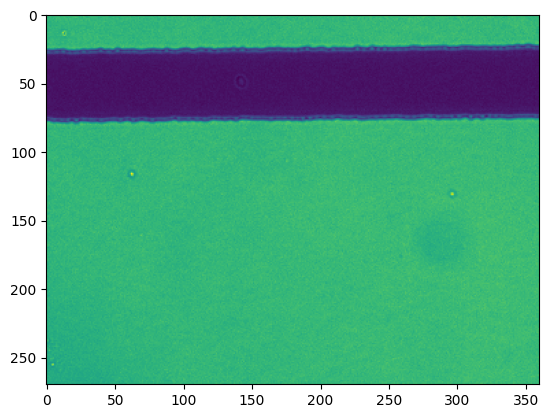

In [269]:
plt.imshow(vid[0][1][::2, ::2])

In [266]:
BL=getBL()
i=500
x_old=0
y_old=0
saturations=[]
# imgs=[]
volumes=[]
hgb=[]
x=[0,0,0]
y=[0,0,0]
I430=[]
I410=[]
video=imgs
frame1=video[i][0:2]
frame2=video[i][2:4]
frame3=video[i][2:6]
frame4=video[i][6:8]
frames=[frame1,frame2, frame3, frame4]
for frame in frames:
    x_old=np.mean(x[-3:])
    y_old=np.mean(y[-3:])
    frame, top, pt430, pt410 = segment(frame,x_old, y_old,BL)
    # print(pt430)
    # print(pt410)
    if pt430[1]>=21 and pt410[1]>21 and pt430[1]<339 and pt410[0]<339 and pt430[0]>11 and pt410[0]>11 and pt430[0]<239 and pt410[0]<239:
        sats, hbmass=saturation(frame)
        saturations.append(sats)
        hgb.append(hbmass)
        # img, vol=net(frames, top)
        # imgs.append(img)
        # volumes.append(vol)
        x.append(pt430[1])
        # y.append(pt410[1])
        # I430.append(blue_top[0])
        # I410.append(blue_top[1])
    else:
        saturations.append(np.nan)
        # volumes.append(np.nan)
        hgb.append(np.nan)
        # imgs.append(np.zeros([81,81,3]))
        x.append(300)
        # I430.append(np.nan)
        # I410.append(np.nan)
i=i+1
plt.imshow(frames[0][0])

ValueError: too many values to unpack (expected 4)